In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (285/285), done.
remote: Total 325 (delta 139), reused 170 (delta 32), pack-reused 0
Receiving objects: 100% (325/325), 11.81 MiB | 14.88 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 17.5 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hyperparameters-tuning/best_params_knn_item.json
/kaggle/input/hyperparameters-tuning/__results__.html
/kaggle/input/hyperparameters-tuning/tuning.db
/kaggle/input/hyperparameters-tuning/__notebook__.ipynb
/kaggle/input/hyperparameters-tuning/__output__.json
/kaggle/input/hyperparameters-tuning/custom.css
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_all_algorithms.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_FunkSVD.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/LICENSE
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/.gitignore
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/README.md
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/run_hyperparameter_search.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/cython_example_SLIM_MSE.py
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/requirements.txt
/kaggle/input/hyperparameters-tuning/Recsys_Challenge_202

# Configurations

In [5]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [6]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [7]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.2159


In [8]:
config = {
    'tune_parameters_item_knn': True,
    'tune_parameters_user_knn': False,
    'tune_parameters_pure_svd': False,
    'tune_parameters_ials': False,
    'database_path': '/kaggle/working/tuning.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': False,
    'train_best_models': False,
    'copy_prev_best_models': False,
    'submit': False,
    'save_github': True
}

In [9]:
try:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/Recsys_Challenge_2023/tuning_results/tuning.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass # if not present optuna will create it

# Data Import

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
train_data.head(5)

,row,col,data
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0


In [12]:
user_ids_test.head(5)

,user_id
0,1
1,2
2,3
3,4
4,5


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478730 entries, 0 to 478729
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   row     478730 non-null  int64  
 1   col     478730 non-null  int64  
 2   data    478730 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [14]:
train_data.describe()

,row,col,data
count,478730.000000,478730.000000,478730.0
mean,6477.521302,4101.952798,1.0
std,3738.435208,5388.639634,0.0
min,1.000000,1.000000,1.0
25%,3204.000000,315.000000,1.0
50%,6493.000000,1575.000000,1.0
75%,9715.000000,5879.000000,1.0
max,13024.000000,22347.000000,1.0


In [15]:
n_users_train = train_data.row.max()
n_users_test = len(user_ids_test.user_id.unique())

print(f'Train number of users: {n_users_train}')
print(f'Test number of users: {n_users_test}')

Train number of users: 13024
Test number of users: 10882


In [16]:
number_of_items = train_data.col.max()

print(f'Number of items: {number_of_items}')

Number of items: 22347


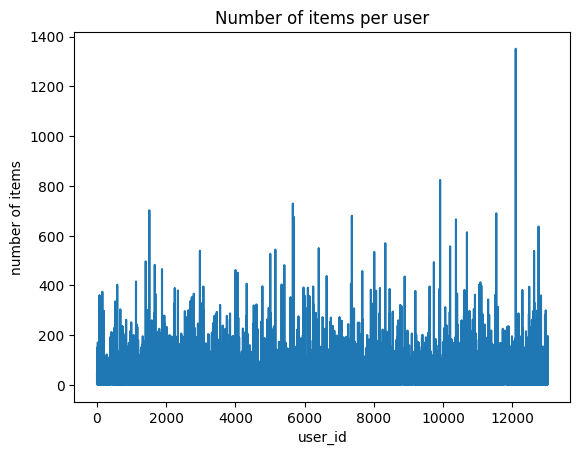

In [17]:
train_data.groupby('row').count().col.plot()
plt.xlabel('user_id')
plt.ylabel('number of items')
plt.title('Number of items per user');

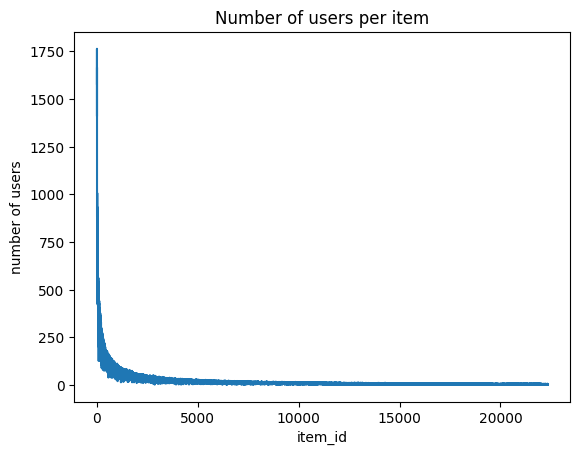

In [18]:
train_data.groupby('col').count().row.plot()
plt.xlabel('item_id')
plt.ylabel('number of users')
plt.title('Number of users per item');

In [19]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Cross Validation Split

In [20]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [21]:
from Data_manager.IncrementalSparseMatrix import IncrementalSparseMatrix


class CrossValidationSplitter:
    def __init__(self, n_splits):
        self.n_splits = n_splits
        self.folds = []
        
    def split(self, URM):
        n_int_per_split = int(URM.nnz / self.n_splits)
        indices = np.arange(0, URM.nnz, 1)
        np.random.shuffle(indices)
        num_users, num_items = URM.shape
        
        URM_all = sps.coo_matrix(URM)
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                indices_valid = indices[n_int_per_split * i:]
                indices_train = indices[:n_int_per_split * i]
            else:
                indices_valid = indices[n_int_per_split * i: n_int_per_split * (i + 1)]
                indices_train_1 = indices[n_int_per_split * max(0, i - 1): n_int_per_split * i]
                indices_train_2 = indices[n_int_per_split * (i + 1):]
                indices_train = np.concatenate((indices_train_1, indices_train_2))
                
            URM_valid_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_train_builder = IncrementalSparseMatrix(
                n_rows=num_users, n_cols=num_items, auto_create_col_mapper=False, 
                auto_create_row_mapper=False
            )
            
            URM_valid_builder.add_data_lists(
                URM_all.row[indices_valid],
                URM_all.col[indices_valid],
                URM_all.data[indices_valid]
            )
            
            URM_train_builder.add_data_lists(
                URM_all.row[indices_train],
                URM_all.col[indices_train],
                URM_all.data[indices_train]
            )
            
            yield URM_train_builder.get_SparseMatrix(), URM_valid_builder.get_SparseMatrix()

# Experiments

In [22]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [23]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [24]:
# recommender = MultiThreadSLIM_SLIMElasticNetRecommender(URM_train)
# recommender.fit(l1_ratio=0.5, alpha=1, positive_only=True, topK=10)

# np.bool = bool
# np.float = float
# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [25]:
# evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
# early_stopping_params = {
#     'epochs_min': 30,
#     'stop_on_validation': True,
#     'validation_every_n': 1,
#     'validation_metric': 'MAP',
#     'lower_validations_allowed': 5,
#     'evaluator_object': evaluator_validation
# }

# recommender = IALSRecommender(URM_train)
# recommender.fit(reg=1e-2, **early_stopping_params)

In [26]:
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [27]:
# recommender = PureSVDRecommender(URM_train)
# recommender.fit(num_factors=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [28]:
# recommender = ItemKNNCFRecommender(URM_train)
# recommender.fit(topK=10, shrink=100)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

In [29]:
# recommender = UserKNNCFRecommender(URM_train)
# recommender.fit(topK=20, shrink=10)

# evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
# result_df, _ = evaluator.evaluateRecommender(recommender)
# result_df

# Hyperparameters tuning

Not considering adjusted cosine and pearson since they remove the mean of the interactions, but here there are all interactions equal to 1

In [30]:
import sqlite3

def print_all_rows(table_name, database_path):
    # Connect to the SQLite database
    connection = sqlite3.connect(database_path)

    # Create a cursor object to execute SQL queries
    cursor = connection.cursor()

    try:
        # Fetch all rows from the specified table
        cursor.execute(f"SELECT * FROM {table_name};")

        # Fetch all rows
        rows = cursor.fetchall()

        # Print the rows
        print(f"All rows from table '{table_name}':")
        for row in rows:
            print(row)

    except sqlite3.Error as e:
        print(f"Error reading data from table '{table_name}': {e}")

    finally:
        # Close the cursor and connection
        cursor.close()
        connection.close()

# Replace 'your_table_name' with the actual table name you want to print
table_name = 'studies'
print_all_rows(table_name, config['database_path'])

All rows from table 'studies':
(1, 'hyperparameters_tuning_ials')


## Item KNN Collaborative Filtering

In [31]:
from concurrent.futures import ThreadPoolExecutor

def evaluate_item_knn(URM_train, URM_valid, similarity, topK, shrink):
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

    evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    print(f'MAP is {result_df.loc[10, "MAP"]}')
    return result_df.loc[10, 'MAP']


def objective_item_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    results = [None] * 10
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
            futures.append(executor.submit(evaluate_item_knn, URM_train, URM_valid, similarity, topK, shrink))
        print(len(futures))
        for j, future in enumerate(futures):
            results[j] = future.result()
        
    return np.mean(results)

In [32]:
%%time

if config['tune_parameters_item_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_item', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_item_knn, n_trials=100)

[I 2023-11-21 18:17:23,717] A new study created in RDB with name: hyperparameters_tuning_knn_item


ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 568 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1151 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 18:20:24,821] Trial 0 finished with value: 0.01659308921139818 and parameters: {'similarity': 'cosine', 'topK': 31, 'shrink': 91}. Best is trial 0 with value: 0.01659308921139818.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1138 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 832 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 18:23:17,155] Trial 1 finished with value: 0.01583458263616168 and parameters: {'similarity': 'dice', 'topK': 342, 'shrink': 105}. Best is trial 0 with value: 0.01659308921139818.



ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 777 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 512 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1458 (11.2%) users with no interactions.
ItemKNNCFRecommender: 

[I 2023-11-21 18:26:27,973] Trial 2 finished with value: 0.01104641202514331 and parameters: {'similarity': 'cosine', 'topK': 921, 'shrink': 493}. Best is trial 0 with value: 0.01659308921139818.


MAP is 0.014316853138471941
ItemKNNCFRecommender: URM Detected 473 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interacti

[I 2023-11-21 18:29:31,898] Trial 3 finished with value: 0.014307381313538212 and parameters: {'similarity': 'tversky', 'topK': 840, 'shrink': 254}. Best is trial 0 with value: 0.01659308921139818.


MAP is 0.01935308364662807
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 222 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 332 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 508 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1126 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1460 (11.2%) users with no interactio

[I 2023-11-21 18:32:27,002] Trial 4 finished with value: 0.014299506952736463 and parameters: {'similarity': 'jaccard', 'topK': 714, 'shrink': 248}. Best is trial 0 with value: 0.01659308921139818.


MAP is 0.020532290349768195
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 503 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 220 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 767 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-21 18:35:16,337] Trial 5 finished with value: 0.013557102219797496 and parameters: {'similarity': 'dice', 'topK': 404, 'shrink': 486}. Best is trial 0 with value: 0.01659308921139818.


MAP is 0.018581978266042617
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 866 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10.9%) users with no interacti

[I 2023-11-21 18:38:06,794] Trial 6 finished with value: 0.014129541599704806 and parameters: {'similarity': 'dice', 'topK': 621, 'shrink': 338}. Best is trial 0 with value: 0.01659308921139818.


MAP is 0.019230498841168127
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interacti

[I 2023-11-21 18:41:00,275] Trial 7 finished with value: 0.013373340783647655 and parameters: {'similarity': 'asymmetric', 'topK': 179, 'shrink': 393}. Best is trial 0 with value: 0.01659308921139818.


MAP is 0.018344442141182856
MAP is 0.01806095998161692
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 565 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 869 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.

[I 2023-11-21 18:43:59,718] Trial 8 finished with value: 0.014735245929280879 and parameters: {'similarity': 'asymmetric', 'topK': 840, 'shrink': 26}. Best is trial 0 with value: 0.01659308921139818.


MAP is 0.02062631467681413
MAP is 0.02119610909335488
ItemKNNCFRecommender: URM Detected 510 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 193 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 773 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 383 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 934 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3

[I 2023-11-21 18:46:54,604] Trial 9 finished with value: 0.017009212921661354 and parameters: {'similarity': 'cosine', 'topK': 42, 'shrink': 14}. Best is trial 9 with value: 0.017009212921661354.


MAP is 0.025468517812580513
MAP is 0.024877396236793633
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 593 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 861 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11

[I 2023-11-21 18:49:43,305] Trial 10 finished with value: 0.015802566170307966 and parameters: {'similarity': 'tanimoto', 'topK': 44, 'shrink': 2}. Best is trial 9 with value: 0.017009212921661354.


MAP is 0.024718481907437317
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 464 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interacti

[I 2023-11-21 18:52:47,768] Trial 11 finished with value: 0.016181386698377515 and parameters: {'similarity': 'cosine', 'topK': 33, 'shrink': 133}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 725 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 379 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1097 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 18:55:53,882] Trial 12 finished with value: 0.014791935205302637 and parameters: {'similarity': 'cosine', 'topK': 228, 'shrink': 99}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 226 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 744 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 352 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 569 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1116 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1454 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 18:59:00,027] Trial 13 finished with value: 0.014452462167036903 and parameters: {'similarity': 'cosine', 'topK': 178, 'shrink': 187}. Best is trial 9 with value: 0.017009212921661354.


MAP is 0.019552592873748584
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1399 (10.7%) users with no interacti

[I 2023-11-21 19:01:52,418] Trial 14 finished with value: 0.016810393342906967 and parameters: {'similarity': 'cosine', 'topK': 11, 'shrink': 56}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 266 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1100 ( 8.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1370 (10.5%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:04:38,005] Trial 15 finished with value: 0.016187939857837376 and parameters: {'similarity': 'tanimoto', 'topK': 507, 'shrink': 43}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 581 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 348 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:07:24,017] Trial 16 finished with value: 0.015276531683416028 and parameters: {'similarity': 'jaccard', 'topK': 307, 'shrink': 192}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:10:11,966] Trial 17 finished with value: 0.016786442306093226 and parameters: {'similarity': 'tversky', 'topK': 159, 'shrink': 53}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 366 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 930 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:13:08,775] Trial 18 finished with value: 0.013435822782841958 and parameters: {'similarity': 'cosine', 'topK': 485, 'shrink': 157}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:15:56,959] Trial 19 finished with value: 0.013194100163090475 and parameters: {'similarity': 'cosine', 'topK': 106, 'shrink': 0}. Best is trial 9 with value: 0.017009212921661354.


MAP is 0.02409273025383098
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 756 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1141 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1470 (11.3%) users with no interactio

[I 2023-11-21 19:18:50,713] Trial 20 finished with value: 0.013219122872341681 and parameters: {'similarity': 'cosine', 'topK': 280, 'shrink': 269}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 183 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 573 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:21:37,386] Trial 21 finished with value: 0.016827785736232184 and parameters: {'similarity': 'tversky', 'topK': 127, 'shrink': 48}. Best is trial 9 with value: 0.017009212921661354.


ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 575 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 256 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 885 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1086 ( 8.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1422 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:24:21,373] Trial 22 finished with value: 0.017131192398282265 and parameters: {'similarity': 'tversky', 'topK': 111, 'shrink': 47}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.024180440007395144
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 228 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 364 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 862 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interacti

[I 2023-11-21 19:27:04,693] Trial 23 finished with value: 0.016684848569391893 and parameters: {'similarity': 'tversky', 'topK': 121, 'shrink': 76}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.023541554804544017
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 246 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 750 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 847 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-21 19:29:50,335] Trial 24 finished with value: 0.015848209138237333 and parameters: {'similarity': 'tversky', 'topK': 247, 'shrink': 136}. Best is trial 22 with value: 0.017131192398282265.


ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 893 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1128 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 850 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1441 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:32:43,502] Trial 25 finished with value: 0.01655579771731742 and parameters: {'similarity': 'tversky', 'topK': 404, 'shrink': 25}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.015414333687000686
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 747 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1156 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interacti

[I 2023-11-21 19:35:33,513] Trial 26 finished with value: 0.016021373284512065 and parameters: {'similarity': 'tversky', 'topK': 99, 'shrink': 205}. Best is trial 22 with value: 0.017131192398282265.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 611 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 743 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 354 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 543 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:38:20,205] Trial 27 finished with value: 0.015830473602975164 and parameters: {'similarity': 'tversky', 'topK': 368, 'shrink': 125}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.017765480541535414MAP is 0.021959245125671555

MAP is 0.022732725566003174
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 241 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1112 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-21 19:41:01,455] Trial 28 finished with value: 0.016485156637314383 and parameters: {'similarity': 'tversky', 'topK': 207, 'shrink': 66}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.023195071477316
MAP is 0.016662534166684173
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 504 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%

[I 2023-11-21 19:43:34,730] Trial 29 finished with value: 0.016537518966596478 and parameters: {'similarity': 'tanimoto', 'topK': 107, 'shrink': 97}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.02328027869349494
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 521 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactio

[I 2023-11-21 19:46:15,944] Trial 30 finished with value: 0.015036382409746765 and parameters: {'similarity': 'asymmetric', 'topK': 54, 'shrink': 325}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.02063073263189781
MAP is 0.020741406303718835
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 589 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 712 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1108 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 888 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1379 (10.

[I 2023-11-21 19:48:56,719] Trial 31 finished with value: 0.016711731181853616 and parameters: {'similarity': 'cosine', 'topK': 26, 'shrink': 63}. Best is trial 22 with value: 0.017131192398282265.


MAP is 0.02403114887800278
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 732 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1131 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactio

[I 2023-11-21 19:51:26,791] Trial 32 finished with value: 0.01779862621687947 and parameters: {'similarity': 'jaccard', 'topK': 13, 'shrink': 26}. Best is trial 32 with value: 0.01779862621687947.


ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 253 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1148 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1440 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:53:58,457] Trial 33 finished with value: 0.014769062367448214 and parameters: {'similarity': 'jaccard', 'topK': 135, 'shrink': 0}. Best is trial 32 with value: 0.01779862621687947.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 603 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1155 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1434 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 19:56:29,047] Trial 34 finished with value: 0.017190417907846745 and parameters: {'similarity': 'jaccard', 'topK': 72, 'shrink': 33}. Best is trial 32 with value: 0.01779862621687947.


MAP is 0.02447844988320387
MAP is 0.021153585409346608
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 584 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 235 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 525 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1143 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 845 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.

[I 2023-11-21 19:59:00,909] Trial 35 finished with value: 0.016758936152188632 and parameters: {'similarity': 'jaccard', 'topK': 71, 'shrink': 84}. Best is trial 32 with value: 0.01779862621687947.


MAP is 0.020922255210152466
MAP is 0.02334492430172122
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1475 (11.

[I 2023-11-21 20:01:36,709] Trial 36 finished with value: 0.016698569963262626 and parameters: {'similarity': 'jaccard', 'topK': 266, 'shrink': 25}. Best is trial 32 with value: 0.01779862621687947.


MAP is 0.02172355333146817
ItemKNNCFRecommender: URM Detected 472 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 507 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 587 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 496 ( 2.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1122 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 833 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interactio

[I 2023-11-21 20:04:18,801] Trial 37 finished with value: 0.01544419581680907 and parameters: {'similarity': 'jaccard', 'topK': 641, 'shrink': 117}. Best is trial 32 with value: 0.01779862621687947.


MAP is 0.01715102694754177
MAP is 0.021636486946521358
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 714 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 342 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1425 (10.

[I 2023-11-21 20:07:05,137] Trial 38 finished with value: 0.014884945407995911 and parameters: {'similarity': 'jaccard', 'topK': 972, 'shrink': 161}. Best is trial 32 with value: 0.01779862621687947.


ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 192 ( 0.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 389 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1195 ( 9.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1443 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:09:41,489] Trial 39 finished with value: 0.014481999790119863 and parameters: {'similarity': 'dice', 'topK': 203, 'shrink': 442}. Best is trial 32 with value: 0.01779862621687947.


ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 184 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 596 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 261 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 550 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1113 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 889 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1456 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:12:20,603] Trial 40 finished with value: 0.016593257555371905 and parameters: {'similarity': 'jaccard', 'topK': 332, 'shrink': 29}. Best is trial 32 with value: 0.01779862621687947.


MAP is 0.0241894238988677
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 325 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1149 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 837 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interaction

[I 2023-11-21 20:15:02,267] Trial 41 finished with value: 0.01706607814535276 and parameters: {'similarity': 'tversky', 'topK': 78, 'shrink': 39}. Best is trial 32 with value: 0.01779862621687947.


ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 597 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 343 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 537 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1461 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:17:33,356] Trial 42 finished with value: 0.017805613576959096 and parameters: {'similarity': 'jaccard', 'topK': 10, 'shrink': 26}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.025888244482879574
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 619 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 935 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1136 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11.0%) users with no interacti

[I 2023-11-21 20:20:06,444] Trial 43 finished with value: 0.016680751386286913 and parameters: {'similarity': 'jaccard', 'topK': 80, 'shrink': 85}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.017899156042440537
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 724 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 377 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 911 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 943 ( 4.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1424 (10.9%) users with no interacti

[I 2023-11-21 20:22:45,999] Trial 44 finished with value: 0.016779827451907016 and parameters: {'similarity': 'jaccard', 'topK': 176, 'shrink': 44}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.016390451331446076
MAP is 0.018545999172455096
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 734 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 380 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 547 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1430 (11

[I 2023-11-21 20:25:19,880] Trial 45 finished with value: 0.01713794678704741 and parameters: {'similarity': 'jaccard', 'topK': 71, 'shrink': 23}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.02531192833220758
MAP is 0.02433775624196571
MAP is 0.024603624238705334
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 729 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 517 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-21 20:27:53,850] Trial 46 finished with value: 0.01684297285999945 and parameters: {'similarity': 'jaccard', 'topK': 22, 'shrink': 107}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.023722085765346977
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 648 ( 5.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 949 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 556 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1183 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 871 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interacti

[I 2023-11-21 20:30:37,103] Trial 47 finished with value: 0.016128238551671746 and parameters: {'similarity': 'jaccard', 'topK': 782, 'shrink': 15}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.022961077497459296
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 186 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 624 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 892 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1421 (10.9%) users with no interacti

[I 2023-11-21 20:33:08,602] Trial 48 finished with value: 0.016463151308957435 and parameters: {'similarity': 'dice', 'topK': 157, 'shrink': 64}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 621 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 757 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 531 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1163 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 900 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1455 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:35:42,318] Trial 49 finished with value: 0.015855908907770715 and parameters: {'similarity': 'jaccard', 'topK': 11, 'shrink': 291}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.02151719532671905
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 586 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 909 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 513 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1137 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1410 (10.8%) users with no interactio

[I 2023-11-21 20:38:14,708] Trial 50 finished with value: 0.015548257923942276 and parameters: {'similarity': 'jaccard', 'topK': 61, 'shrink': 372}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 719 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 912 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 536 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 863 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1391 (10.7%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:40:53,558] Trial 51 finished with value: 0.016649447935582932 and parameters: {'similarity': 'asymmetric', 'topK': 72, 'shrink': 35}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 927 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 529 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1165 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:43:24,506] Trial 52 finished with value: 0.016552028552588378 and parameters: {'similarity': 'jaccard', 'topK': 141, 'shrink': 76}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.023664113541067316
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 187 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 607 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 239 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 915 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 570 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1145 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 905 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interacti

[I 2023-11-21 20:45:55,730] Trial 53 finished with value: 0.016888648322573703 and parameters: {'similarity': 'tanimoto', 'topK': 83, 'shrink': 11}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 501 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 758 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 549 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:48:34,723] Trial 54 finished with value: 0.01673094314487954 and parameters: {'similarity': 'tversky', 'topK': 209, 'shrink': 40}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 928 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 519 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1135 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 865 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1463 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:51:07,045] Trial 55 finished with value: 0.017081604733082508 and parameters: {'similarity': 'jaccard', 'topK': 14, 'shrink': 95}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1171 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 908 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1445 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:53:38,043] Trial 56 finished with value: 0.01612904699530639 and parameters: {'similarity': 'jaccard', 'topK': 52, 'shrink': 224}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.022091770765715082
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 250 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 891 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1427 (11.0%) users with no interacti

[I 2023-11-21 20:56:06,344] Trial 57 finished with value: 0.017110440917084153 and parameters: {'similarity': 'jaccard', 'topK': 12, 'shrink': 97}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 182 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 633 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 751 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 349 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1449 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 20:58:36,283] Trial 58 finished with value: 0.01622086189838462 and parameters: {'similarity': 'jaccard', 'topK': 118, 'shrink': 142}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 752 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1139 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1407 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:01:19,219] Trial 59 finished with value: 0.016188540409441177 and parameters: {'similarity': 'jaccard', 'topK': 530, 'shrink': 20}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.023760572833912856
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 628 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 240 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 328 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1453 (11.2%) users with no interacti

[I 2023-11-21 21:03:52,501] Trial 60 finished with value: 0.01638761916551686 and parameters: {'similarity': 'dice', 'topK': 170, 'shrink': 62}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.02305582448511005
ItemKNNCFRecommender: URM Detected 480 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 167 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 599 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 746 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 347 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 558 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 882 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1428 (11.0%) users with no interactio

[I 2023-11-21 21:06:21,444] Trial 61 finished with value: 0.017066866462773563 and parameters: {'similarity': 'jaccard', 'topK': 16, 'shrink': 93}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.01598376539601792
MAP is 0.024050556711357654
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 244 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 730 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 369 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1418 (10.

[I 2023-11-21 21:08:51,563] Trial 62 finished with value: 0.01716895059639198 and parameters: {'similarity': 'jaccard', 'topK': 41, 'shrink': 54}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 612 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 759 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 899 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 851 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:11:22,887] Trial 63 finished with value: 0.01718111510719911 and parameters: {'similarity': 'jaccard', 'topK': 52, 'shrink': 53}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 497 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 600 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 779 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 355 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 562 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1175 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1462 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:13:58,264] Trial 64 finished with value: 0.014731077898073092 and parameters: {'similarity': 'jaccard', 'topK': 104, 'shrink': 0}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.024642488818731843
MAP is 0.02408280323316992
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 475 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 727 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 924 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1121 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 854 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1413 (10.

[I 2023-11-21 21:16:44,463] Trial 65 finished with value: 0.01662802809993643 and parameters: {'similarity': 'asymmetric', 'topK': 55, 'shrink': 56}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.02344516634242436
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 160 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 631 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 735 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 337 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 922 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 864 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1459 (11.2%) users with no interactio

[I 2023-11-21 21:19:19,538] Trial 66 finished with value: 0.01667390074641478 and parameters: {'similarity': 'jaccard', 'topK': 139, 'shrink': 75}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.018274262259917927
MAP is 0.015758565701465343
MAP is 0.02357923274580742
ItemKNNCFRecommender: URM Detected 478 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 613 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 742 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 925 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1164 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecomme

[I 2023-11-21 21:21:54,464] Trial 67 finished with value: 0.017187768387542816 and parameters: {'similarity': 'tanimoto', 'topK': 47, 'shrink': 49}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.02467058116458512
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 960 ( 7.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 553 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 821 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1438 (11.0%) users with no interactio

[I 2023-11-21 21:24:31,674] Trial 68 finished with value: 0.017462241481911868 and parameters: {'similarity': 'tanimoto', 'topK': 45, 'shrink': 17}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.02523227039877137
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 620 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 738 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 534 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1169 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1436 (11.0%) users with no interactio

[I 2023-11-21 21:27:08,158] Trial 69 finished with value: 0.016659576275023458 and parameters: {'similarity': 'tanimoto', 'topK': 44, 'shrink': 112}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 577 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 248 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 774 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 345 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1170 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 860 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:29:44,213] Trial 70 finished with value: 0.016516715369430477 and parameters: {'similarity': 'tanimoto', 'topK': 240, 'shrink': 50}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.017935218089446946
MAP is 0.021138382359701075
MAP is 0.023269033494005643
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 484 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 616 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 769 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 351 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 940 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1168 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 849 ( 3.8%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-21 21:32:19,125] Trial 71 finished with value: 0.017361782277699307 and parameters: {'similarity': 'tanimoto', 'topK': 89, 'shrink': 31}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 188 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 749 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 375 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 890 ( 6.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 574 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 857 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:34:51,595] Trial 72 finished with value: 0.01701953064299243 and parameters: {'similarity': 'tanimoto', 'topK': 47, 'shrink': 10}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.018550930305897176
MAP is 0.02453719349778384
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 583 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 737 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1109 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1420 (10.

[I 2023-11-21 21:37:25,143] Trial 73 finished with value: 0.017289850179488676 and parameters: {'similarity': 'tanimoto', 'topK': 99, 'shrink': 27}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 921 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1473 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:39:58,300] Trial 74 finished with value: 0.01713766498557342 and parameters: {'similarity': 'tanimoto', 'topK': 95, 'shrink': 33}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.023726108861183898
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 181 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 602 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 231 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 929 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1119 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 887 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interacti

[I 2023-11-21 21:42:34,393] Trial 75 finished with value: 0.017020422822254876 and parameters: {'similarity': 'tanimoto', 'topK': 148, 'shrink': 17}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 462 ( 3.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 486 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 579 ( 4.4%) users with no interactions.
ItemKNNCFRecommender: URM Detected 258 ( 1.2%) items with no interactions.
ItemKNNCFRecommender: URM Detected 733 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 346 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 901 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 542 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 878 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1423 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:45:11,109] Trial 76 finished with value: 0.01649357620575729 and parameters: {'similarity': 'tanimoto', 'topK': 194, 'shrink': 73}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 604 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 225 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 741 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1142 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:47:43,862] Trial 77 finished with value: 0.016915011458164812 and parameters: {'similarity': 'tanimoto', 'topK': 113, 'shrink': 32}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 179 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 506 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 162 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 610 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 251 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 367 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 931 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1161 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 829 ( 3.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1469 (11.3%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 21:50:18,026] Trial 78 finished with value: 0.016432923414471005 and parameters: {'similarity': 'tanimoto', 'topK': 93, 'shrink': 5}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.022373294887434836
MAP is 0.018979299307199816
ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 481 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 185 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 357 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 907 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 561 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1134 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 846 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1405 (10

[I 2023-11-21 21:52:57,411] Trial 79 finished with value: 0.016176536292489906 and parameters: {'similarity': 'tanimoto', 'topK': 447, 'shrink': 45}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.023189711141291945
MAP is 0.023256711082798052
MAP is 0.017487569644470565
ItemKNNCFRecommender: URM Detected 476 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 595 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 234 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 753 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 378 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 906 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 540 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 877 ( 3.9%) items with no interactions.
ItemKNNCFRecomm

[I 2023-11-21 21:55:29,835] Trial 80 finished with value: 0.015237522040908318 and parameters: {'similarity': 'tanimoto', 'topK': 38, 'shrink': 472}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.019207145689081426
MAP is 0.020328230789282708
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 161 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 359 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 914 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 580 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1162 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 879 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1429 (11

[I 2023-11-21 21:58:03,368] Trial 81 finished with value: 0.017294063073945425 and parameters: {'similarity': 'tanimoto', 'topK': 42, 'shrink': 56}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.02441591106038516
MAP is 0.024654910332303024
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 617 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 237 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 783 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 344 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 942 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 544 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1185 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 848 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1450 (11.

[I 2023-11-21 22:00:37,588] Trial 82 finished with value: 0.01717249054512903 and parameters: {'similarity': 'tanimoto', 'topK': 76, 'shrink': 27}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 489 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 469 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 163 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 638 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 731 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 340 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 926 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1157 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 840 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1457 (11.2%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:03:13,668] Trial 83 finished with value: 0.016677882605074114 and parameters: {'similarity': 'tanimoto', 'topK': 136, 'shrink': 63}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.024071091685479846
MAP is 0.023350103458364604
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 626 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 755 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 358 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 941 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 522 ( 2.3%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1147 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 918 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1444 (11

[I 2023-11-21 22:05:48,948] Trial 84 finished with value: 0.01743824777025694 and parameters: {'similarity': 'tanimoto', 'topK': 34, 'shrink': 42}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.011714337765638303
MAP is 0.024723712025444773
ItemKNNCFRecommender: URM Detected 490 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 157 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 479 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 173 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 227 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 335 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 546 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1130 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 842 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10

[I 2023-11-21 22:08:28,203] Trial 85 finished with value: 0.01727672683838998 and parameters: {'similarity': 'tanimoto', 'topK': 36, 'shrink': 17}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.0193718965654002
MAP is 0.022066866863691602
MAP is 0.025388010972195778
ItemKNNCFRecommender: URM Detected 491 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 176 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 635 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 739 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 374 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 548 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1167 ( 9.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 895 ( 4.0%) items with no interactions.
ItemKNNCFRecommen

[I 2023-11-21 22:11:16,185] Trial 86 finished with value: 0.016081009613785228 and parameters: {'similarity': 'tanimoto', 'topK': 587, 'shrink': 12}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.024454041077291398
ItemKNNCFRecommender: URM Detected 500 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 166 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 601 ( 4.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 245 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 771 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 350 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 916 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 526 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1146 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 876 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1451 (11.1%) users with no interacti

[I 2023-11-21 22:13:58,261] Trial 87 finished with value: 0.017337420291025106 and parameters: {'similarity': 'tanimoto', 'topK': 94, 'shrink': 22}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.024179521262483187
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 505 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 177 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 255 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 760 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 948 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 592 ( 2.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 896 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1471 (11.3%) users with no interacti

[I 2023-11-21 22:16:41,152] Trial 88 finished with value: 0.017098898291380445 and parameters: {'similarity': 'tanimoto', 'topK': 117, 'shrink': 19}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 496 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 485 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 606 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 772 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 361 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 936 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 533 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1132 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 883 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1437 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:19:25,107] Trial 89 finished with value: 0.01762554724416577 and parameters: {'similarity': 'tanimoto', 'topK': 28, 'shrink': 38}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 499 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 174 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 165 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 608 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 252 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 784 ( 6.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 329 ( 1.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 923 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 551 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1160 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 853 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1487 (11.4%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:22:07,434] Trial 90 finished with value: 0.016826888891912768 and parameters: {'similarity': 'tanimoto', 'topK': 91, 'shrink': 84}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 498 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 474 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 622 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 249 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 726 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 371 ( 1.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 932 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1124 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 870 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1431 (11.0%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:24:50,329] Trial 91 finished with value: 0.017666284190448404 and parameters: {'similarity': 'tanimoto', 'topK': 28, 'shrink': 37}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.025152009478857512
MAP is 0.025209610051095024
ItemKNNCFRecommender: URM Detected 483 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 502 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 180 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 588 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 236 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 728 ( 5.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 356 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 920 ( 7.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 541 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1110 ( 8.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 897 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1417 (10

[I 2023-11-21 22:27:28,573] Trial 92 finished with value: 0.0176969014312923 and parameters: {'similarity': 'tanimoto', 'topK': 11, 'shrink': 36}. Best is trial 42 with value: 0.017805613576959096.


MAP is 0.025368974927571303
MAP is 0.02532947287873808
ItemKNNCFRecommender: URM Detected 494 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 169 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 482 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 170 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 590 ( 4.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 242 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 768 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 910 ( 7.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 555 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1120 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 894 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1447 (11.

[I 2023-11-21 22:30:04,703] Trial 93 finished with value: 0.017496949571975683 and parameters: {'similarity': 'tanimoto', 'topK': 25, 'shrink': 37}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 717 ( 5.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 362 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 933 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 554 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1129 ( 8.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 913 ( 4.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1414 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:32:41,549] Trial 94 finished with value: 0.017661276955481725 and parameters: {'similarity': 'tanimoto', 'topK': 16, 'shrink': 38}. Best is trial 42 with value: 0.017805613576959096.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 171 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 471 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 178 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 614 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 233 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 748 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 902 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 560 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1154 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 859 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1409 (10.8%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:35:28,291] Trial 95 finished with value: 0.01781513442797406 and parameters: {'similarity': 'tanimoto', 'topK': 12, 'shrink': 37}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.0255675562706037
ItemKNNCFRecommender: URM Detected 487 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 492 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 615 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 243 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 740 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 363 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 945 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 532 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1115 ( 8.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 872 ( 3.9%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1446 (11.1%) users with no interaction

[I 2023-11-21 22:38:16,337] Trial 96 finished with value: 0.01774972537526433 and parameters: {'similarity': 'tanimoto', 'topK': 12, 'shrink': 41}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 495 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 164 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 493 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 168 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 637 ( 4.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 754 ( 5.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 365 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 956 ( 7.3%) users with no interactions.
ItemKNNCFRecommender: URM Detected 545 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1179 ( 9.1%) users with no interactions.
ItemKNNCFRecommender: URM Detected 884 ( 4.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1426 (10.9%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:41:14,541] Trial 97 finished with value: 0.01510955115611834 and parameters: {'similarity': 'tanimoto', 'topK': 14, 'shrink': 0}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 488 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 470 ( 3.6%) users with no interactions.
ItemKNNCFRecommender: URM Detected 175 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 618 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 238 ( 1.1%) items with no interactions.
ItemKNNCFRecommender: URM Detected 736 ( 5.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 904 ( 6.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 563 ( 2.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1153 ( 8.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 855 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1448 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:44:23,053] Trial 98 finished with value: 0.01732254893907951 and parameters: {'similarity': 'tanimoto', 'topK': 29, 'shrink': 65}. Best is trial 95 with value: 0.01781513442797406.


ItemKNNCFRecommender: URM Detected 511 ( 3.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 172 ( 0.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 477 ( 3.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 159 ( 0.7%) items with no interactions.
ItemKNNCFRecommender: URM Detected 609 ( 4.7%) users with no interactions.
ItemKNNCFRecommender: URM Detected 232 ( 1.0%) items with no interactions.
ItemKNNCFRecommender: URM Detected 766 ( 5.9%) users with no interactions.
ItemKNNCFRecommender: URM Detected 360 ( 1.6%) items with no interactions.
ItemKNNCFRecommender: URM Detected 939 ( 7.2%) users with no interactions.
ItemKNNCFRecommender: URM Detected 527 ( 2.4%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1152 ( 8.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 858 ( 3.8%) items with no interactions.
ItemKNNCFRecommender: URM Detected 1452 (11.1%) users with no interactions.
ItemKNNCFRecommender: U

[I 2023-11-21 22:47:35,395] Trial 99 finished with value: 0.01632312228561235 and parameters: {'similarity': 'cosine', 'topK': 62, 'shrink': 80}. Best is trial 95 with value: 0.01781513442797406.


MAP is 0.023531415637599057
MAP is 0.023128804499371308
CPU times: user 6h 5min 53s, sys: 1h 26min 37s, total: 7h 32min 31s
Wall time: 4h 30min 12s


In [33]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [35]:
if config['tune_parameters_item_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [36]:
if config['tune_parameters_item_knn']:
    with open('/kaggle/working/best_params_knn_item.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_item.json', 
            'tuning_results/best_params_knn_item.json', 
            'Item KNN tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_item.json', 
        '/kaggle/working/best_params_knn_item.json'
    )

## User KNN Collaborative Filtering

In [37]:
def objective_user_knn(trial):
    similarity = trial.suggest_categorical('similarity', ["cosine", "asymmetric", "dice", "jaccard", "tanimoto", "tversky"])
    topK = trial.suggest_int('topK', 10, 1000)
    shrink = trial.suggest_int('shrink', 0, 500)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        recommender = UserKNNCFRecommender(URM_train)
        recommender.fit(topK=topK, shrink=shrink, similarity=similarity)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [38]:
%%time

if config['tune_parameters_user_knn']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_knn_user',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_user_knn, n_trials=75)

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 13.4 µs


In [39]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [41]:
if config['tune_parameters_user_knn']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [42]:
if config['tune_parameters_user_knn']:
    with open('/kaggle/working/best_params_knn_user.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_knn_user.json', 
            'tuning_results/best_params_knn_user.json', 
            'User KNN tuning results (from kaggle notebook)'
        )
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_knn_user.json', 
        '/kaggle/working/best_params_knn_user.json'
    )

## PureSVD

In [43]:
%%time

def evaluate_pure_svd(URM_train, URM_valid, num_factors):
    recommender = PureSVDRecommender(URM_train)
    recommender.fit(num_factors=num_factors)

    evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(recommender)
    return result_df.loc[10, 'MAP']

if config['tune_parameters_pure_svd']:
    n_factors = np.arange(5, 501, 5)
    map_results = []

    for i, factors in enumerate(n_factors):
        
        results = [None] * 10
        with ThreadPoolExecutor(max_workers=10) as executor:
            futures = []
            for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
                futures.append(executor.submit(evaluate_pure_svd, URM_train, URM_valid, factors))
            for j, future in enumerate(futures):
                results[j] = future.result()
        map_results.append(np.mean(results))
        PrintColor(f'End trial {i}, with factors = {factors}: MAP is {np.mean(results)}')

CPU times: user 7 µs, sys: 2 µs, total: 9 µs
Wall time: 12.6 µs


In [44]:
# sorted_indices = np.argsort(n_factors)
if config['tune_parameters_pure_svd']:
    plt.plot(n_factors, np.array(map_results))
    plt.xlabel('Factors')
    plt.ylabel('MAP')
    plt.title('Pure SVD Recommender')
    plt.show()

In [45]:
if config['tune_parameters_pure_svd']:
    params = {'factors': int(n_factors[np.argsort(map_results)[-1]])}

    with open('/kaggle/working/pure_svd_params.json', 'w') as params_file:
        json.dump(params, params_file)
        
    trials = pd.DataFrame({'factor': n_factors, 'MAP': np.array(map_results)})
    trials.to_csv('/kaggle/working/pure_svd_trials.csv', index=False)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/pure_svd_params.json', 
            'tuning_results/pure_svd_params.json', 
            'Pure SVD tuning best params (from kaggle notebook)'
        )
        
        upload_file(
            '/kaggle/working/pure_svd_trials.csv', 
            'tuning_results/pure_svd_trials.csv',
            'Pure SVD tuning trial results (from kaggle notebook)'
        )
        
elif config['copy_prev_best_params']:
    try:
        shutil.copyfile(
            '/kaggle/input/hyperparameters-tuning/pure_svd_params.json', 
            '/kaggle/working/pure_svd_params.json'
        )
    except FileNotFoundError:
        pass # not already tuned

# Alternating Least Squares

In [46]:
def objective_ials(trial):
    reg = trial.suggest_float('reg', 1e-5, 1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 1)
    num_factors = trial.suggest_int('num_factors', 10, 200)
    
    map_sum = 0
    for URM_train, URM_valid in CrossValidationSplitter(10).split(URM_all):
        evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        early_stopping_params = {
            'epochs_min': 1,
            'stop_on_validation': True,
            'validation_every_n': 1,
            'validation_metric': 'MAP',
            'lower_validations_allowed': 3,
            'evaluator_object': evaluator_validation
        }

        recommender = IALSRecommender(URM_train)
        recommender.fit(reg=reg, alpha=alpha, num_factors=num_factors, **early_stopping_params)

        evaluator = EvaluatorHoldout(URM_valid, cutoff_list=[10])
        result_df, _ = evaluator.evaluateRecommender(recommender)
        map_sum += result_df.loc[10, 'MAP']
    return map_sum / 10

In [47]:
%%time

if config['tune_parameters_ials']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_ials',
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_ials, n_trials=5)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.3 µs


In [48]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [49]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [50]:
if config['tune_parameters_ials']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [51]:
if config['tune_parameters_ials']:
    with open('/kaggle/working/best_params_ials.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_ials.json', 
            'tuning_results/best_params_ials.json', 
            'IALS tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/hyperparameters-tuning/best_params_ials.json', 
        '/kaggle/working/best_params_ials.json'
    )

In [52]:
if config['save_github'] and (config['tune_parameters_user_knn'] or config['tune_parameters_item_knn'] or config['tune_parameters_ials']):
    upload_file(
        config['database_path'], 
        'tuning_results/tuning.db', 
        'Tuning db updated results (from kaggle notebook)'
    )

# Training best model

In [53]:
# with open('/kaggle/working/best_params_knn_item.json', 'r') as params_file:
#     params_knn = json.load(params_file)

# recommender = ItemKNNCFRecommender(URM_all)
# recommender.fit(topK=params_knn['topK'], shrink=params_knn['shrink'], similarity=params_knn['similarity'])

# Submission

In [54]:
# user_ids_test.info()

In [55]:
# user_ids_test.head(5)

In [56]:
# user_ids_test['user_id'].unique()

In [57]:
# # user_id and item_id start from 1
# recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# submission_df.head()

In [58]:
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)